# Emotion Detection through NLP: ComplementNB vs. RNN and CNN

# Helpers

In [1]:
import re
import pandas as pd
import seaborn as sns
from typing import Union
import nltk
from nltk import corpus, stem
import numpy as np
from collections import namedtuple
import tensorflow as tf
from keras.layers import TextVectorization
from sklearn import metrics
import pickle

In [2]:
sns.set_style(
    "whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False}
)
sns.set_context(
    "paper", font_scale=2,
    rc={"axes.labelsize": 15, "xtick.labelsize": 15, "ytick.labelsize": 15, 'axes.formatter.min_exponent': 1}
)

In [3]:
nltk.download('wordnet')
WORD_LEMMA = stem.WordNetLemmatizer()
nltk.download('stopwords')
STOPWORDS = corpus.stopwords.words('english')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
LABELS_MAP = {'sadness': 0, 'love': 1, 'anger': 2, 'joy': 3, 'fear': 4, 'surprise': 5}

In [5]:
DATA_PATH = '/content/drive/MyDrive/data/emotion_data/'

In [6]:
def loadDFdata(path: str = 'train', clean: bool = False) -> pd.DataFrame:
    ds = []
    with open(f'{DATA_PATH}{path}.txt') as f:
        for line in f:
            tok, label = line[:-1].split(';', maxsplit=1)
            ds.append([tok, label])
        f.close()
    ds = pd.DataFrame(ds, columns=['token', 'label'])
    if not clean: return ds
    ds['token'] = ds['token'].apply(standardization)
    return ds

In [7]:
def load_vocabulary_data(path: str = 'train', clean: bool = True) -> list:
    voc_data = []
    with open(f'{DATA_PATH}{path}.txt') as f:
        for line in f:
            tok, _ = line[:-1].split(';')
            if clean: tok = standardization(tok)
            voc_data.append(tok)
        f.close()
    return voc_data

In [8]:
def standardization(token: str) -> str:
    token = re.sub('[^0-9a-zA-Z]', ' ', token)
    token = [WORD_LEMMA.lemmatize(word.lower(), pos='a') for word in token.split() if word not in STOPWORDS]
    return ' '.join(token)

In [9]:
def load_DS(clean: bool = False) -> tuple:
   data = namedtuple('ds', 'train, test, val')
   return data(loadDFdata('train', clean), loadDFdata('test', clean), loadDFdata('val', clean))

In [10]:
def loadTFdata(path: str = 'train', clean: bool = True, vectorizer: Union[TextVectorization, None] = None) -> tf.data.Dataset:
    ds = loadDFdata(path, clean=clean)
    ds['label'] = ds['label'].map(LABELS_MAP)
    x = ds['token']
    y = tf.keras.utils.to_categorical(ds['label'])
    if vectorizer is not None: x = vectorizer(x)
    tf_ds = tf.data.Dataset.from_tensor_slices((x, y), path)
    return tf_ds

In [11]:
def save_vectorizer(vectorizer: TextVectorization, path: str):
    pickle.dump(
        {
            'config': vectorizer.get_config(),
            'weights': vectorizer.get_weights()
        },
        open(f"{path}.pkl", "wb")
    )

In [12]:
def load_vectorizer(path: str) -> TextVectorization:
    config = pickle.load(open(f"{path}.pkl", "rb"))
    vectorizer = TextVectorization.from_config(config['config'])
    vectorizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    vectorizer.set_weights(config['weights'])
    return vectorizer

# Data Preprocessing and Analyzing

In [ ]:
def describe(ds: pd.DataFrame, data_name: str = ''):
    desc = f'_____________________________\n{data_name} description:\n\n' \
           f'Size: {ds.shape[0]}\nNones: {ds.isnull().sum().sum()}\n' \
           f'Target:\n{ds["label"].value_counts()}\n_____________________________'
    print(desc)

In [ ]:
DS = load_DS(clean=False)

In [ ]:
print(DS.train.head())

                                               token    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


**Tain data**

_____________________________
Train data description:

Size: 16000
Nones: 0
Target:
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64
_____________________________


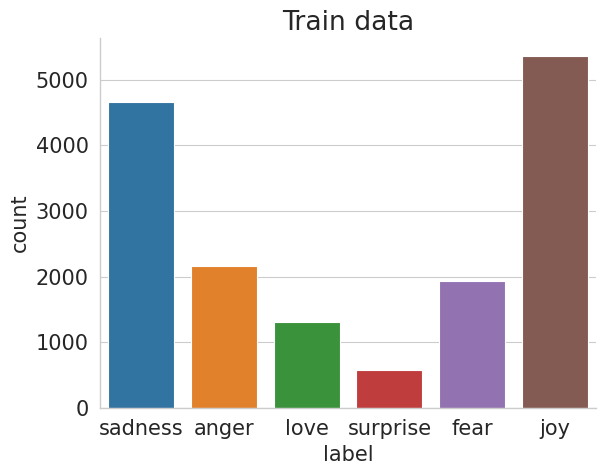

In [ ]:
ax = sns.countplot(data=DS.train, x='label')
ax.set_title('Train data')
describe(DS.train, data_name='Train data')

**Test data**

_____________________________
Test data description:

Size: 2000
Nones: 0
Target:
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64
_____________________________


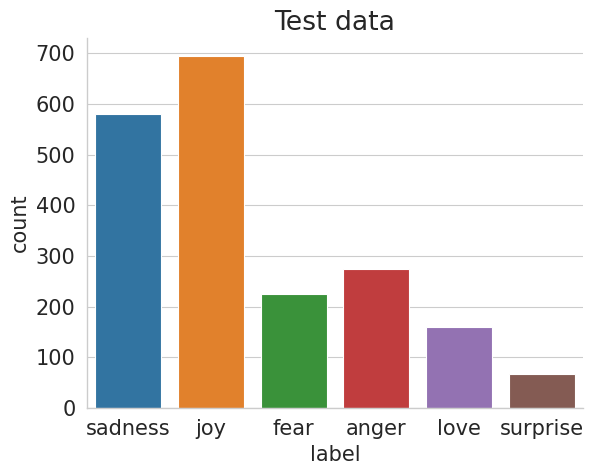

In [ ]:
ax = sns.countplot(data=DS.test, x='label')
ax.set_title('Test data')
describe(DS.test, data_name='Test data')

**Validation data**

_____________________________
Val data description:

Size: 2000
Nones: 0
Target:
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: label, dtype: int64
_____________________________


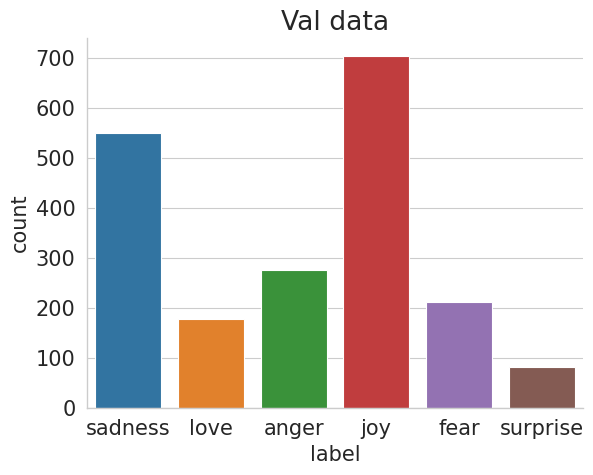

In [ ]:
ax = sns.countplot(data=DS.val, x='label')
ax.set_title('Val data')
describe(DS.val, data_name='Val data')

**sentence size**

Text(0.5, 1.0, 'Train data befor cleaning')

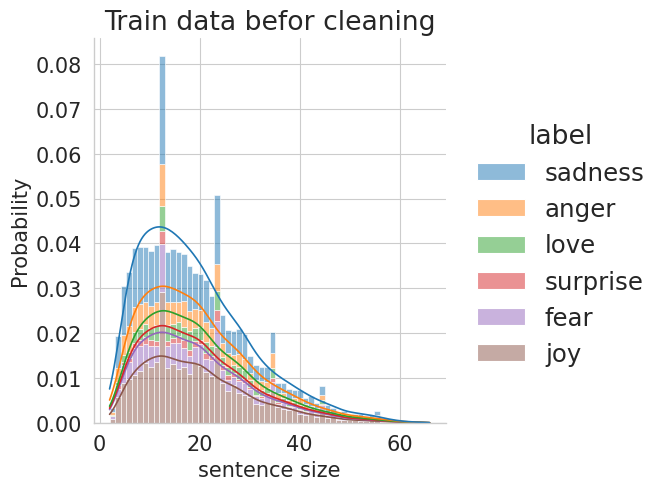

In [ ]:
DS.train['sentence size'] = DS.train['token'].apply(lambda s: len(s.split()))
ax = sns.displot(DS.train, x="sentence size", hue='label', kde=True, stat="probability", multiple="stack")
ax.ax.set_title('Train data befor cleaning')

Text(0.5, 1.0, 'Train data after cleaning')

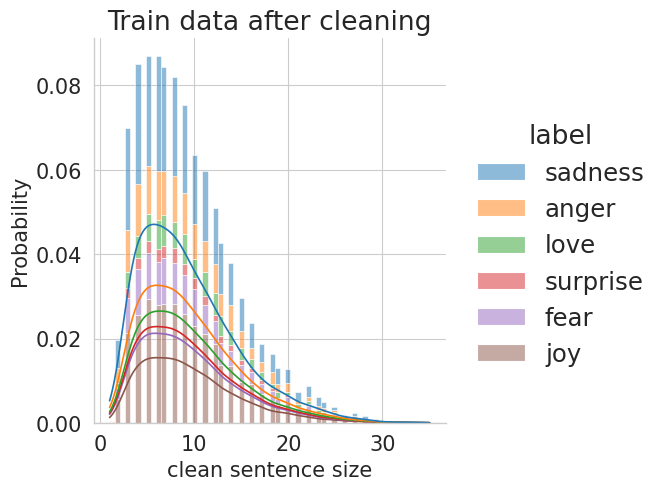

In [ ]:
DS.train['token clean'] = DS.train['token'].apply(standardization)
DS.train['clean sentence size'] = DS.train['token clean'].apply(lambda s: len(s.split()))
ax = sns.displot(DS.train, x="clean sentence size", hue='label', kde=True, stat="probability", multiple="stack")
ax.ax.set_title('Train data after cleaning')

In [ ]:
print(f'\nBefore cleaning: \n{DS.train["token"].head()}')
print(f'\nAfter cleaning: \n{DS.train["token clean"].head()}')


Before cleaning: 
0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: token, dtype: object

After cleaning: 
0                                didnt feel humiliated
1    go feeling hopeless damned hopeful around some...
2            im grabbing minute post feel greedy wrong
3    ever feeling nostalgic fireplace know still pr...
4                                      feeling grouchy
Name: token clean, dtype: object


Text(0.5, 1.0, 'Test data after cleaning')

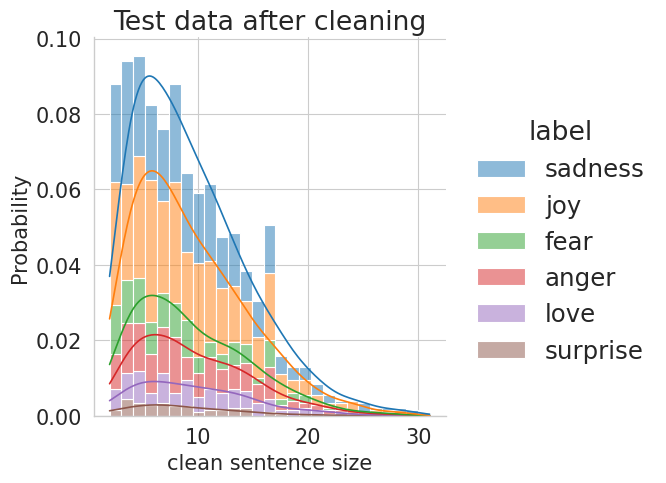

In [ ]:
DS.test['token clean'] = DS.test['token'].apply(standardization)
DS.test['clean sentence size'] = DS.test['token clean'].apply(lambda s: len(s.split()))
ax = sns.displot(DS.test, x="clean sentence size", hue='label', kde=True, stat="probability", multiple="stack")
ax.ax.set_title('Test data after cleaning')

Text(0.5, 1.0, 'Val data after cleaning')

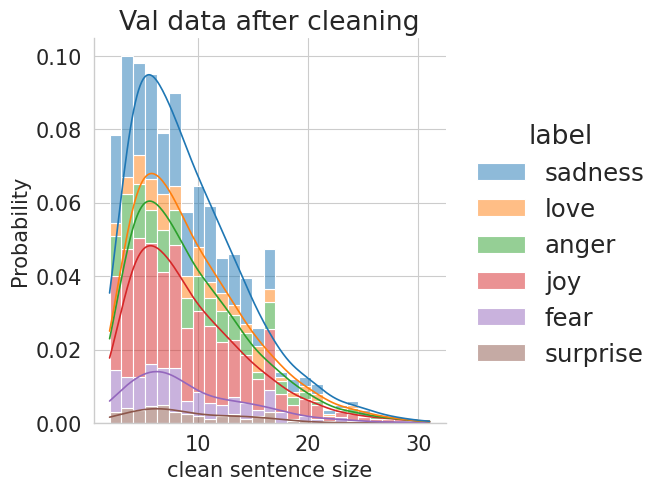

In [ ]:
DS.val['token clean'] = DS.val['token'].apply(standardization)
DS.val['clean sentence size'] = DS.val['token clean'].apply(lambda s: len(s.split()))
ax = sns.displot(DS.val, x="clean sentence size", hue='label', kde=True, stat="probability", multiple="stack")
ax.ax.set_title('Val data after cleaning')

In [ ]:
words = DS.train['token clean']
words.index = DS.train['label']
words_group = words.groupby(['label']).apply(lambda y: y.str.cat(sep=' '))

most_common = []
for lab in words_group.index:
    txt = words_group[lab]
    word_dist = nltk.FreqDist(nltk.tokenize.word_tokenize(txt))
    most_common += [[lab, com[0], com[1]] for com in word_dist.most_common(20)]

most_common = pd.DataFrame(most_common, columns=['label', 'word', 'freq'])
for g, gdf in most_common.groupby(['label']):
  print(f'Label: {g}\n {gdf[["word", "freq"]]}\n\n')

Label: anger
        word  freq
0      feel  1459
1   feeling   721
2      like   384
3        im   342
4    really   124
5       get   121
6      time   118
7      know   115
8    little   105
9    people   105
10     want    98
11     even    95
12    would    89
13    angry    85
14      way    85
15    think    81
16   things    80
17      one    79
18    could    79
19      bit    77


Label: fear
          word  freq
20       feel  1212
21    feeling   742
22         im   322
23       like   258
24     little   149
25        bit   117
26       know   117
27     really   100
28     people    87
29       want    85
30      still    84
31       time    83
32    strange    79
33        get    78
34      think    75
35    nervous    75
36  terrified    74
37      going    72
38      would    71
39    anxious    71


Label: joy
          word  freq
40       feel  3928
41    feeling  1539
42       like  1006
43         im   799
44     really   309
45       good   297
46       time   290

<ipython-input-31-9a8289752884>:12: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, gdf in most_common.groupby(['label']):


# ML Approach

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
DS = load_DS(clean=True)
for ds in DS: ds['label'] = ds['label'].map(LABELS_MAP)

**TF-IDF features**

In [ ]:
tv_ds = pd.concat((DS.train, DS.val), axis=0).reset_index(drop=True)

vectorizer = TfidfVectorizer()
X_tr = vectorizer.fit_transform(tv_ds['token'])
Y_tr = tv_ds['label']

**Choosing model**

models:

- ComplementNB (Complement Naive Bayes):

    - Effective for handling imbalanced datasets and fast.

- LinearSVC (Linear Support Vector Classifier):
    - Works well for high-dimensional data (big vocabolury) and multiclass classification.

- LogisticRegression:
    - can help in understanding the linear relationships between features and target classes.

- RandomForestClassifier (Ensemble learning):
    - It can capture complex patterns and relationships in the data, including interactions between words in text data

In [ ]:
models = [
    (ComplementNB(), 'ComplementNB'),
    (LinearSVC(), 'LinearSVC'),
    (LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg'), 'LogisticRegression'),
    (RandomForestClassifier(n_estimators=100, max_depth=5), 'RandomForest')
]

In [ ]:
events = []
for model, name in models:
    eve = cross_validate(model, X_tr, Y_tr, scoring='accuracy', cv=10)
    for i, (acc, t1, t2) in enumerate(zip(eve['test_score'], eve['fit_time'], eve['score_time'])):
      events.append([name, i + 1, t1, t2, acc])

events = pd.DataFrame(events, columns=['Est.', 'CV', 'Fit time', 'Score time', 'Accuracy'])
events['Err'] = events['Est.'].map(events.groupby(['Est.']).apply(lambda x: x['Accuracy'].std()))

In [ ]:
print(f"Mean Accuracy:\n {events.groupby(['Est.']).apply(lambda x: x['Accuracy'].mean())}")

Mean Accuracy:
 Est.
ComplementNB          0.881500
LinearSVC             0.894000
LogisticRegression    0.865611
RandomForest          0.343000
dtype: float64


In [ ]:
print(f"Mean Err:\n {events.groupby(['Est.']).apply(lambda x: x['Accuracy'].std())}")

Mean Err:
 Est.
ComplementNB          0.006774
LinearSVC             0.008219
LogisticRegression    0.008552
RandomForest          0.003335
dtype: float64


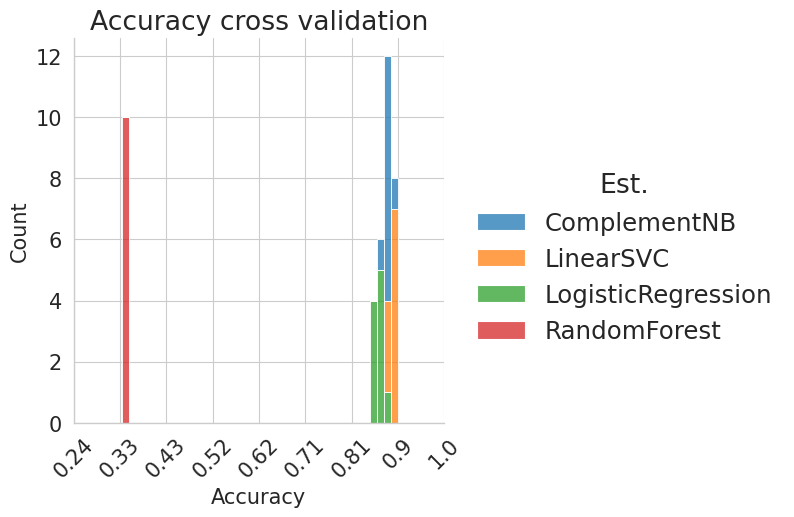

In [ ]:
ax = sns.displot(
    events, x="Accuracy", hue="Est.", element='bars', bins=40, multiple="stack"
)
_ = ax.ax.set_xlim([events['Accuracy'].min() - 0.1, 1])
_ = ax.ax.set_xticks(
    np.linspace(events['Accuracy'].min() - 0.1, 1, 9),
    np.round_(np.linspace(events['Accuracy'].min() - 0.1, 1, 9), 2), rotation=45
)
_ = ax.ax.set_title('Accuracy cross validation')

In [ ]:
print(f"Mean Fit time:\n {events.groupby(['Est.']).apply(lambda x: x['Fit time'].mean())}")

Mean Fit time:
 Est.
ComplementNB          0.010287
LinearSVC             0.274597
LogisticRegression    1.495122
RandomForest          1.448259
dtype: float64


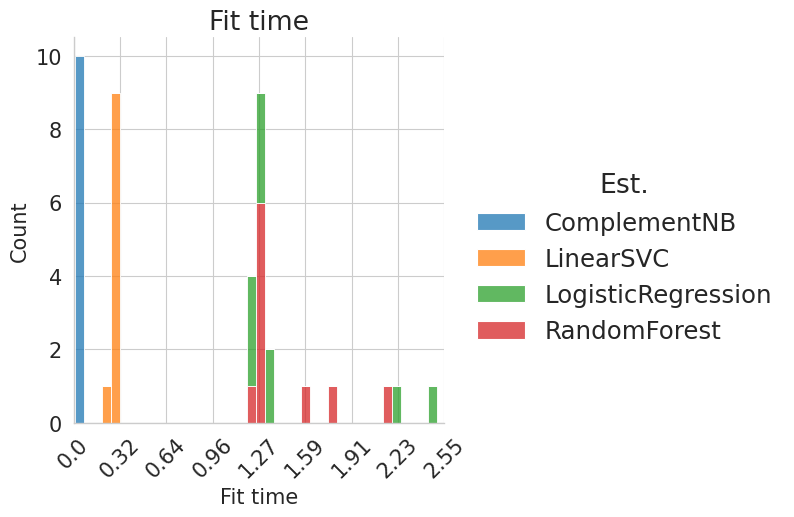

In [ ]:
ax = sns.displot(
    events, x="Fit time", hue="Est.", element='bars', bins=40, multiple="stack"
)
_ = ax.ax.set_xlim([0, events['Fit time'].max() + 0.05])
_ = ax.ax.set_xticks(
    np.linspace(0, events['Fit time'].max() + 0.05, 9),
    np.round_(np.linspace(0, events['Fit time'].max() + 0.05, 9), 2), rotation=45
)
_ = ax.ax.set_title('Fit time')

In [ ]:
print(f"Mean Score time:\n {events.groupby(['Est.']).apply(lambda x: x['Score time'].mean())}")

Mean Score time:
 Est.
ComplementNB          0.001630
LinearSVC             0.001572
LogisticRegression    0.003265
RandomForest          0.027012
dtype: float64


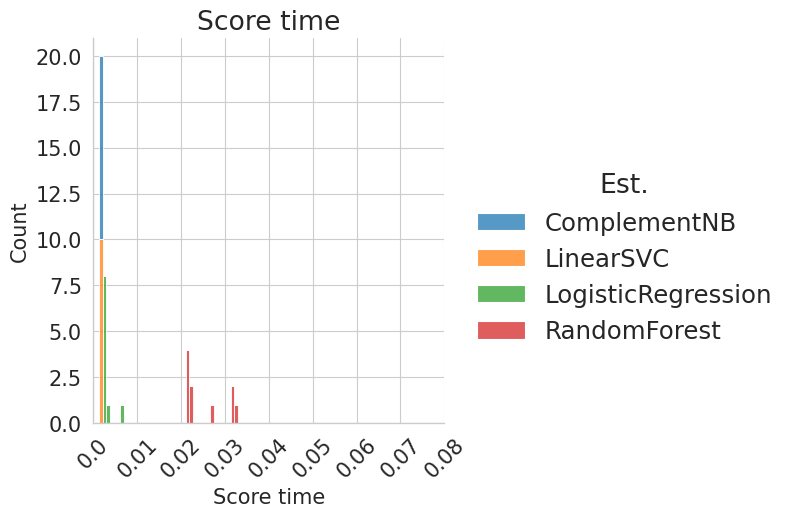

In [ ]:
ax = sns.displot(
    events, x="Score time", hue="Est.", element='bars', bins=40, multiple="stack"
)
_ = ax.ax.set_xlim([0, events['Score time'].max() + 0.05])
_ = ax.ax.set_xticks(
    np.linspace(0, events['Score time'].max() + 0.05, 9),
    np.round_(np.linspace(0, events['Score time'].max() + 0.05, 9), 2), rotation=45
)
_ = ax.ax.set_title('Score time')

**Hyperparameter tuning for TF-IDF features**

In [ ]:
pipeline = Pipeline( [("vect", TfidfVectorizer()), ("clf", ComplementNB())])
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}

In [ ]:
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=50,
    random_state=0,
    n_jobs=2,
    verbose=1
)
search.fit(DS.train['token'], DS.train['label'])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('clf', ComplementNB())]),
                   n_iter=50, n_jobs=2,
                   param_distributions={'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                                        'vect__max_df': (0.2, 0.4, 0.6, 0.8,
                                                         1.0),
                                        'vect__min_df': (1, 3, 5, 10),
                                        'vect__ngram_range': ((1, 1), (1, 2)),
                                        'vect__norm': ('l1', 'l2')},
                   random_state=0, verbose=1)

In [ ]:
print("Best parameters combination found:")
best_parameters = search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")
print(
    f"\nAccuracy of the best parameters"
    f": {search.best_score_:.3f}"
)
print(
    f"\nAccuracy of validation:"
    f"{search.score(DS.val['token'], DS.val['label']):.3f}"
)

Best parameters combination found:
clf__alpha: 1.0
vect__max_df: 0.4
vect__min_df: 5
vect__ngram_range: (1, 2)
vect__norm: l1

Accuracy of the best parameters: 0.905

Accuracy of validation:0.908


# ComplementNB Classifier

In [ ]:
pipeline = Pipeline([
    ("vect", TfidfVectorizer(norm='l1', max_df=0.4, min_df=5, ngram_range=(1, 2))),
    ("clf", ComplementNB(alpha=1.0))
])

In [ ]:
pipeline.fit(tv_ds['token'], tv_ds['label'])

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.4, min_df=5, ngram_range=(1, 2),
                                 norm='l1')),
                ('clf', ComplementNB())])

In [ ]:
y_pred = pipeline.predict(DS.test['token'])

In [ ]:
print(metrics.classification_report(DS.test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       581
           1       0.78      0.82      0.80       159
           2       0.90      0.92      0.91       275
           3       0.92      0.93      0.93       695
           4       0.88      0.87      0.87       224
           5       0.75      0.65      0.70        66

    accuracy                           0.91      2000
   macro avg       0.86      0.85      0.86      2000
weighted avg       0.90      0.91      0.90      2000



Text(42.91666666666667, 0.5, 'True')

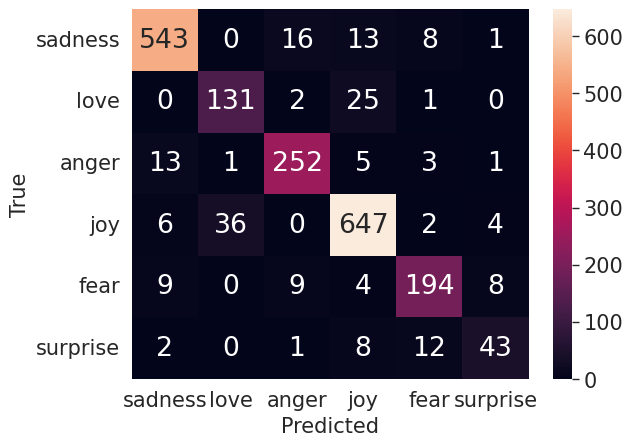

In [ ]:
conf_mat = metrics.confusion_matrix(DS.test['label'], y_pred)
ax = sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    xticklabels=list(LABELS_MAP.keys()),
    yticklabels=list(LABELS_MAP.keys())
)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

The substantial overlap in occurrences of "love" and "joy" as false positives can be rationalized, as they are both positive emotions that frequently intersect within the realm of emotional experiences. same case for fear and surprise.

# DP Approach

In [13]:
from keras.layers import LSTM, Concatenate, Dropout, Dense, Input, Embedding, Flatten, Conv1D, MaxPool1D, TextVectorization, Bidirectional

In [14]:
def build_glove_wights(vocabulary: TextVectorization,embedding_dim: int = 100) -> tuple[np.ndarray, np.ndarray]:
    vocabulary_ = vocabulary.get_vocabulary()[2:]
    if embedding_dim not in [50, 100, 200, 300]:
        raise ValueError('embedding dim need to be 50/100/200 or 300')

    vocabulary_map = dict(zip(vocabulary_, range(2, len(vocabulary_) + 2)))
    glove_wights = np.zeros((len(vocabulary_map) + 2, embedding_dim), dtype='float32')
    found_map = np.zeros((len(vocabulary_map) + 2,), dtype=bool)

    with open(f'{DATA_PATH}glove.6B.{embedding_dim}d.txt', encoding="utf-8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            if not len(word) or word not in vocabulary_map: continue
            idx = vocabulary_map[word]
            glove_wights[idx] = np.fromstring(coefs, "f", sep=" ")
            del vocabulary_map[word]
            found_map[idx] = True
        f.close()
    print(f'Converted {found_map.sum()} words misses {len(vocabulary_map)}')
    return glove_wights, found_map

In [15]:
def get_vectorizer(max_tokens: Union[int, None], output_sequence_length: int, ngrams: Union[int, tuple], output_mode: str = 'int', split: str = 'whitespace', adapt: str = 'train') -> TextVectorization:
    vectorizer = TextVectorization(
        max_tokens=max_tokens,
        output_mode=output_mode,
        split=split,
        output_sequence_length=output_sequence_length,
        ngrams=ngrams
    )
    vectorizer.adapt(load_vocabulary_data(adapt, clean=True))
    return vectorizer

In [16]:
def evaluate_model(model: tf.keras.Model) -> pd.DataFrame:
    history = model.history
    steps = len(history.history['accuracy'])
    hist_df = pd.DataFrame()
    hist_df['ACC'] = history.history['accuracy'] + history.history['val_accuracy']
    hist_df['Loss'] = history.history['loss'] + history.history['val_loss']
    hist_df['Fold'] = ['Train'] * steps + ['Val'] * steps
    hist_df['Epoch'] = list(range(1, steps + 1)) + list(range(1, steps + 1))
    return hist_df

In [17]:
def model_callbacks(checkpoint_path: str, early_stopping: bool = True, patience: int = 5) -> list:
    callbacks = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_path,
          save_weights_only=True,
          monitor='val_accuracy',
          mode='auto',
          save_best_only=True
      )
    ]
    if early_stopping:
      callbacks.append(
          tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
          )
      )
    return callbacks

In [18]:
def cnn(
        vocabulary_size: int,
        sequence_size: int,
        features: int = 128,
        embedding_dim: int = 100,
        n_classes: int = 2,
        kernels_size: Union[None, list, tuple] = None,
        embedding_wights: Union[None, tf.Tensor] = None,
        kernel_initializer=None,
        bias_initializer=None,
        dropout: float = 0.0,
        name: str = 'CnnModel'
) -> tf.keras.Model:
    kernels_size = kernels_size if kernels_size is not None else [3, 4, 5]

    if embedding_wights is not None:
        embeddings_initializer = tf.keras.initializers.Constant(embedding_wights)
    else:
        embeddings_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05)

    embedding = Embedding(
        vocabulary_size,
        embedding_dim,
        embeddings_initializer=embeddings_initializer,
        input_length=sequence_size,
        trainable=embedding_wights is None,
        name='Embedding'
    )

    ki_ = tf.keras.initializers.TruncatedNormal
    bi_ = tf.keras.initializers.Constant

    inputs = Input(shape=[sequence_size, ], dtype=tf.int64, name='Input')
    X = embedding(inputs)
    conv_pool = []

    for i, k in enumerate(kernels_size):
        x_conv = Conv1D(
            features,
            kernel_size=k,
            padding='VALID',
            activation='relu',
            kernel_initializer=ki_(stddev=0.1) if kernel_initializer is None else kernel_initializer,
            bias_initializer=bi_(value=0) if bias_initializer is None else bias_initializer,
            name=f'Conv{i}RELU'
        )(X)
        x_pool = MaxPool1D(
            pool_size=sequence_size - k + 1,
            name=f'MaxPoll{i}'
        )(x_conv)
        conv_pool.append(x_pool)

    h_pool = Concatenate(axis=1, name='Concate')(conv_pool)
    h_pool = Flatten(name='FC')(h_pool)

    if dropout > 0: h_pool = Dropout(dropout, name='Drop')(h_pool)
    outputs = Dense(
        n_classes,
        activation='softmax',
        name='FC_softmax'
    )(h_pool)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [19]:
def rnn(
        vocabulary_size: int,
        sequence_size: int,
        units: Union[list, int] = 256,
        n_cells: int = 3,
        embedding_dim: int = 128,
        embedding_wights: Union[None, tf.Tensor] = None,
        bidirectional: bool = True,
        kernel_initializer=None,
        bias_initializer=None,
        recurrent_initializer=None,
        n_classes: int = 2,
        dropout: float = 0.0,
        recurrent_dropout: float = 0.0,
        name: str = 'RnnModel'
) -> tf.keras.Model:

    if embedding_wights is not None:
        embeddings_initializer = tf.keras.initializers.Constant(embedding_wights)
    else:
        embeddings_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05)

    if isinstance(units, int): units = [units] * n_cells

    ki_ = tf.keras.initializers.GlorotUniform
    bi_ = tf.keras.initializers.Zeros
    ri_ = tf.keras.initializers.Orthogonal

    inputs = Input(shape=[sequence_size, ], dtype=tf.int64)

    X = Embedding(
        vocabulary_size,
        embedding_dim,
        embeddings_initializer=embeddings_initializer,
        input_length=sequence_size,
        trainable=embedding_wights is None,
        name='Embedding'
    )(inputs)

    for i, u in enumerate(units):
        cell = LSTM(
            u,
            return_sequences=i != (len(units) - 1),
            activation='tanh',
            recurrent_activation='sigmoid',
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_initializer=ki_() if kernel_initializer is None else kernel_initializer,
            bias_initializer=bi_() if bias_initializer is None else bias_initializer,
            recurrent_initializer=ri_(gain=1.0) if recurrent_initializer is None else recurrent_initializer,
            name=f'LTSM{i}'
        )
        if bidirectional: cell = Bidirectional(cell, name=f'Bi_LTSM{i}')
        X = cell(X)

    outputs = Dense(
        n_classes,
        activation='softmax',
        name='fc_softmax'
    )(X)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [20]:
SEQUENCE_SIZE = 60
BUFFER_SIZE = 10
BATCH_SIZE = 32
EPOCHS = 50

# CNN model with glove embedding features

In [ ]:
EMBEDDING_DIM = 100
VOCAB_SIZE = None
NGRAMS = 1

In [ ]:
vectorizer = get_vectorizer(VOCAB_SIZE, SEQUENCE_SIZE, ngrams=NGRAMS, adapt='train')
VOCAB_SIZE = vectorizer.vocabulary_size()

In [ ]:
embedding_wights, _ = build_glove_wights(vocabulary=vectorizer, embedding_dim=EMBEDDING_DIM)

Converted 13950 words misses 997


In [ ]:
cnn_model = cnn(
    vocabulary_size=VOCAB_SIZE,
    features=512,
    sequence_size=SEQUENCE_SIZE,
    embedding_dim=EMBEDDING_DIM,
    n_classes=len(LABELS_MAP),
    kernels_size=[3, 4, 5],
    embedding_wights=embedding_wights,
    dropout=0.5
)

In [ ]:
cnn_model.summary()

Model: "CnnModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 60)]                 0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 60, 100)              1494900   ['Input[0][0]']               
                                                                                                  
 Conv0RELU (Conv1D)          (None, 58, 512)              154112    ['Embedding[0][0]']           
                                                                                                  
 Conv1RELU (Conv1D)          (None, 57, 512)              205312    ['Embedding[0][0]']           
                                                                                           

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
callbacks = model_callbacks('weights_cnn_glove', True, 5)

In [ ]:
train_ds = loadTFdata('train', clean=True, vectorizer=vectorizer).shuffle(1000, reshuffle_each_iteration=False).batch(BATCH_SIZE)
val_ds = loadTFdata('val', clean=True, vectorizer=vectorizer).shuffle(500, reshuffle_each_iteration=False).batch(BATCH_SIZE)

In [ ]:
cnn_model.fit(train_ds, epochs=EPOCHS, verbose=1, callbacks=callbacks, validation_data=val_ds)

In [ ]:
hist_df = evaluate_model(cnn_model)

Text(0.5, 1.0, 'Accuracy per epoch')

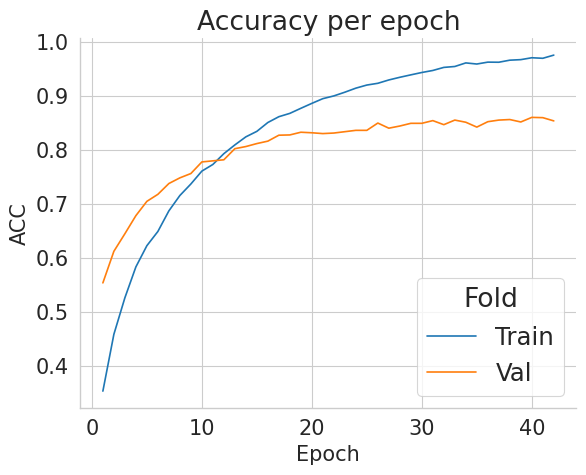

In [ ]:
ax = sns.lineplot(data=hist_df, x="Epoch", y="ACC", hue="Fold")
ax.set_title('Accuracy per epoch')

Text(0.5, 1.0, 'Loss per epoch')

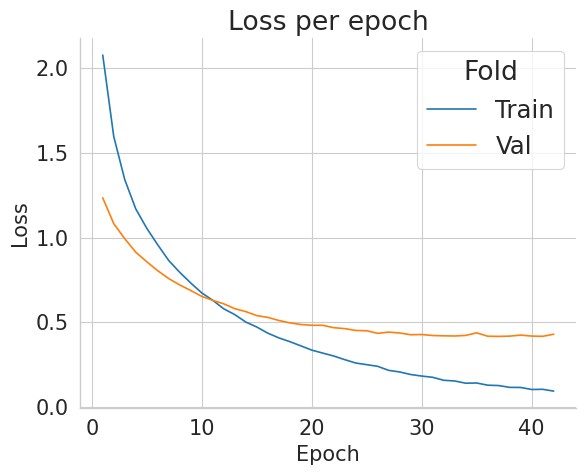

In [ ]:
ax = sns.lineplot(data=hist_df, x="Epoch", y="Loss", hue="Fold")
ax.set_title('Loss per epoch')

In [ ]:
test_ds = loadTFdata('test', clean=True, vectorizer=vectorizer)

In [ ]:
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
cnn_model.load_weights('weights_cnn_glove')

In [ ]:
cnn_model.evaluate(test_ds, verbose=1)

63/63 [==============================] - 0s 5ms/step - loss: 0.4284 - accuracy: 0.8495


[0.4284122884273529, 0.8495000004768372]

In [ ]:
test_ds = loadDFdata('test', True)
X = vectorizer(test_ds['token'])

In [ ]:
y_pred = cnn_model.predict(X)

63/63 [==============================] - 0s 4ms/step


In [ ]:
y_pred = y_pred.argmax(axis=-1)

In [ ]:
y_true = test_ds['label'].map(LABELS_MAP).values

In [ ]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       581
           1       0.78      0.55      0.64       159
           2       0.83      0.88      0.85       275
           3       0.85      0.93      0.89       695
           4       0.83      0.80      0.82       224
           5       0.69      0.50      0.58        66

    accuracy                           0.85      2000
   macro avg       0.81      0.76      0.78      2000
weighted avg       0.85      0.85      0.85      2000



Text(42.91666666666667, 0.5, 'True')

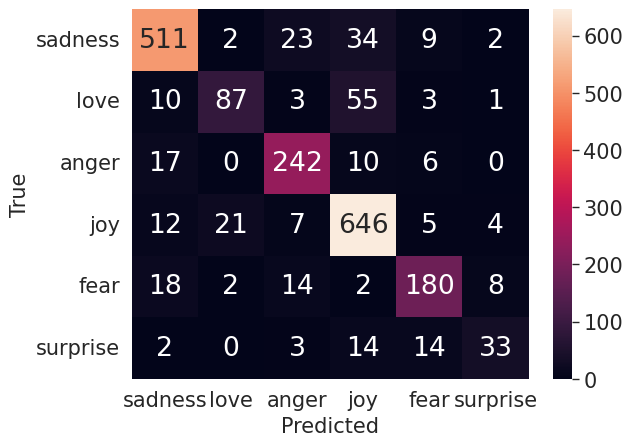

In [ ]:
conf_mat = metrics.confusion_matrix(y_true, y_pred)
ax = sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    xticklabels=list(LABELS_MAP.keys()),
    yticklabels=list(LABELS_MAP.keys())
)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [ ]:
save_vectorizer(vectorizer, 'cnn_glove_vectorizer')

# CNN model with training Embedding layer

In [ ]:
NGRAMS = (1, 2)
EMBEDDING_DIM = 128
VOCAB_SIZE = 10000

In [ ]:
vectorizer = get_vectorizer(VOCAB_SIZE, SEQUENCE_SIZE, ngrams=NGRAMS, adapt='train')

In [ ]:
cnn_model = cnn(
    vocabulary_size=VOCAB_SIZE,
    features=512,
    sequence_size=SEQUENCE_SIZE,
    embedding_dim=EMBEDDING_DIM,
    n_classes=len(LABELS_MAP),
    kernels_size=[3, 4, 5],
    embedding_wights=None,
    dropout=0.5
)
cnn_model.summary()

Model: "CnnModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 60)]                 0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 60, 128)              1280000   ['Input[0][0]']               
                                                                                                  
 Conv0RELU (Conv1D)          (None, 58, 512)              197120    ['Embedding[0][0]']           
                                                                                                  
 Conv1RELU (Conv1D)          (None, 57, 512)              262656    ['Embedding[0][0]']           
                                                                                           

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.01),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
callbacks = model_callbacks('weights_cnn', True, 4)

In [ ]:
train_ds = loadTFdata('train', clean=True, vectorizer=vectorizer).shuffle(1000, reshuffle_each_iteration=False).batch(BATCH_SIZE)
val_ds = loadTFdata('val', clean=True, vectorizer=vectorizer).shuffle(500, reshuffle_each_iteration=False).batch(BATCH_SIZE)

In [ ]:
cnn_model.fit(train_ds, epochs=EPOCHS, verbose=1, callbacks=callbacks, validation_data=val_ds)

In [ ]:
hist_df = evaluate_model(cnn_model)

Text(0.5, 1.0, 'Accuracy per epoch')

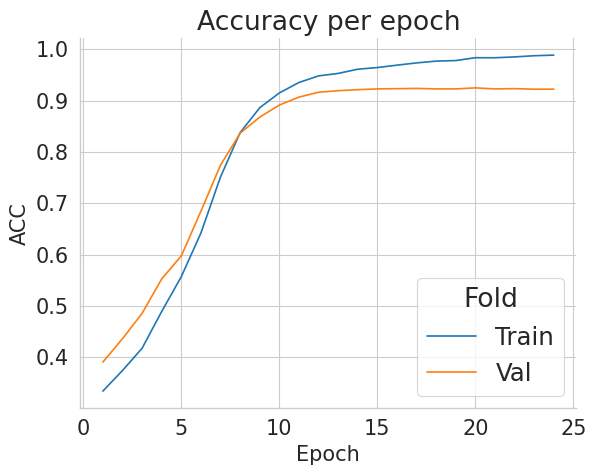

In [ ]:
ax = sns.lineplot(data=hist_df, x="Epoch", y="ACC", hue="Fold")
ax.set_title('Accuracy per epoch')

Text(0.5, 1.0, 'Loss per epoch')

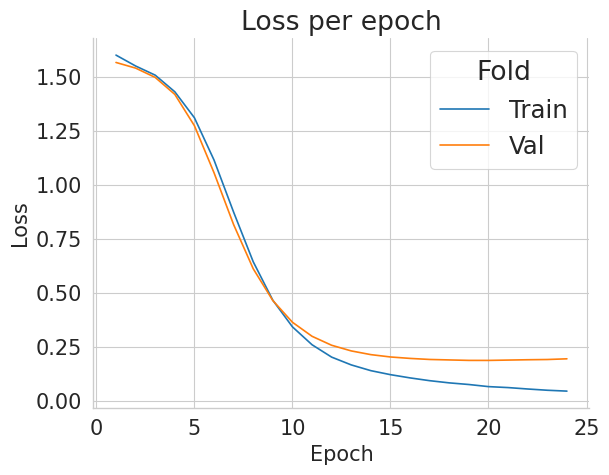

In [ ]:
ax = sns.lineplot(data=hist_df, x="Epoch", y="Loss", hue="Fold")
ax.set_title('Loss per epoch')

In [ ]:
test_ds = loadTFdata('test', clean=True, vectorizer=vectorizer).batch(BATCH_SIZE)

In [ ]:
cnn_model.load_weights('weights_cnn')

In [ ]:
cnn_model.evaluate(test_ds, verbose=1)

63/63 [==============================] - 0s 6ms/step - loss: 0.1873 - accuracy: 0.9140


[0.18730103969573975, 0.9139999747276306]

In [ ]:
test_ds = loadDFdata('test', True)
X = vectorizer(test_ds['token'])
y_pred = cnn_model.predict(X)
y_pred = y_pred.argmax(axis=-1)
y_true = test_ds['label'].map(LABELS_MAP).values

63/63 [==============================] - 0s 4ms/step


In [ ]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       581
           1       0.79      0.81      0.80       159
           2       0.91      0.92      0.92       275
           3       0.94      0.95      0.94       695
           4       0.87      0.88      0.87       224
           5       0.75      0.67      0.70        66

    accuracy                           0.91      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.91      0.91      0.91      2000



Text(42.91666666666667, 0.5, 'True')

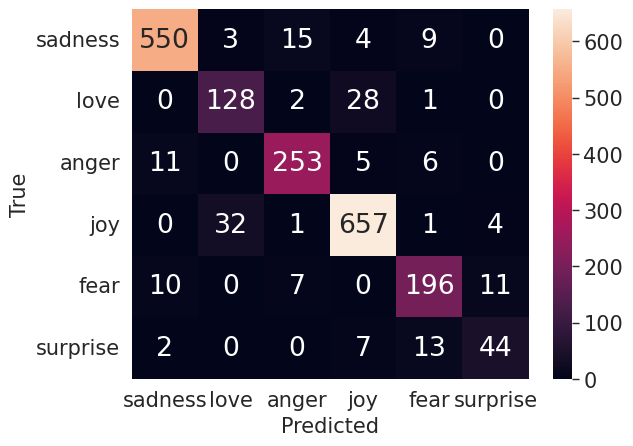

In [ ]:
conf_mat = metrics.confusion_matrix(y_true, y_pred)
ax = sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    xticklabels=list(LABELS_MAP.keys()),
    yticklabels=list(LABELS_MAP.keys())
)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [ ]:
save_vectorizer(vectorizer, 'cnn_vectorizer')

# RNN - LTSM with glove embedding features

In [ ]:
NGRAMS = 1
EMBEDDING_DIM = 100
VOCAB_SIZE = None

In [ ]:
vectorizer = get_vectorizer(VOCAB_SIZE, SEQUENCE_SIZE, ngrams=NGRAMS, adapt='train')
VOCAB_SIZE = vectorizer.vocabulary_size()

In [ ]:
embedding_wights, _ = build_glove_wights(vocabulary=vectorizer, embedding_dim=EMBEDDING_DIM)

Converted 13950 words misses 997


In [ ]:
rnn_model = rnn(
    vocabulary_size=VOCAB_SIZE,
    sequence_size=SEQUENCE_SIZE,
    units=[256, 128, 64],
    embedding_dim=EMBEDDING_DIM,
    embedding_wights=embedding_wights,
    bidirectional=True,
    n_classes=len(LABELS_MAP),
    dropout=0.2,
    recurrent_dropout=0.0
)
rnn_model.summary()

Model: "RnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60)]              0         
                                                                 
 Embedding (Embedding)       (None, 60, 100)           1494900   
                                                                 
 Bi_LTSM0 (Bidirectional)    (None, 60, 512)           731136    
                                                                 
 Bi_LTSM1 (Bidirectional)    (None, 60, 256)           656384    
                                                                 
 Bi_LTSM2 (Bidirectional)    (None, 128)               164352    
                                                                 
 fc_softmax (Dense)          (None, 6)                 774       
                                                                 
Total params: 3047546 (11.63 MB)
Trainable params: 1552646

In [ ]:
rnn_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=0.01),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
callbacks = model_callbacks('weights_rnn_glove', True, 4)

In [ ]:
train_ds = loadTFdata('train', clean=True, vectorizer=vectorizer).shuffle(1000, reshuffle_each_iteration=False).batch(BATCH_SIZE)
val_ds = loadTFdata('val', clean=True, vectorizer=vectorizer).shuffle(500, reshuffle_each_iteration=False).batch(BATCH_SIZE)

In [ ]:
rnn_model.fit(train_ds, epochs=EPOCHS, verbose=1, callbacks=callbacks, validation_data=val_ds)

In [ ]:
hist_df = evaluate_model(rnn_model)

Text(0.5, 1.0, 'Accuracy per epoch')

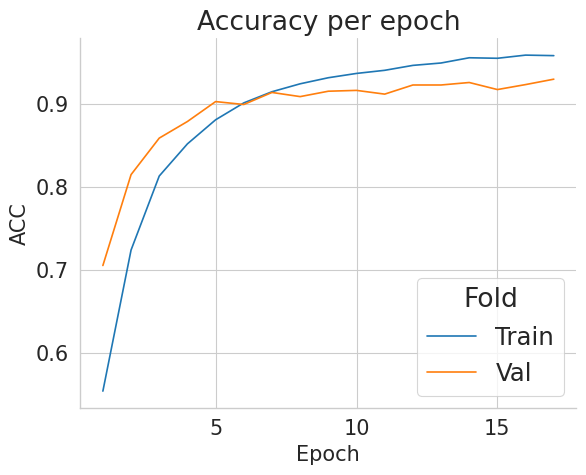

In [ ]:
ax = sns.lineplot(data=hist_df, x="Epoch", y="ACC", hue="Fold")
ax.set_title('Accuracy per epoch')

Text(0.5, 1.0, 'Loss per epoch')

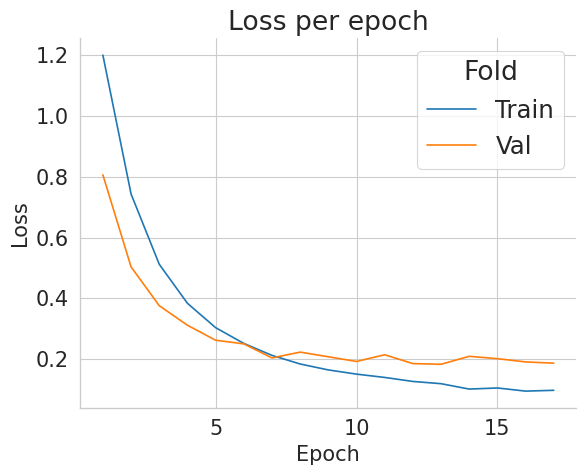

In [ ]:
ax = sns.lineplot(data=hist_df, x="Epoch", y="Loss", hue="Fold")
ax.set_title('Loss per epoch')

In [ ]:
test_ds = loadTFdata('test', clean=True, vectorizer=vectorizer).batch(BATCH_SIZE)

In [ ]:
rnn_model.load_weights('weights_rnn_glove')

In [ ]:
rnn_model.evaluate(test_ds, verbose=1)

63/63 [==============================] - 1s 17ms/step - loss: 0.1877 - accuracy: 0.9235


[0.18767298758029938, 0.9235000014305115]

In [ ]:
test_ds = loadDFdata('test', True)
X = vectorizer(test_ds['token'])
y_pred = rnn_model.predict(X)
y_pred = y_pred.argmax(axis=-1)
y_true = test_ds['label'].map(LABELS_MAP).values

63/63 [==============================] - 3s 11ms/step


In [ ]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       581
           1       0.81      0.85      0.83       159
           2       0.93      0.91      0.92       275
           3       0.93      0.94      0.94       695
           4       0.90      0.92      0.91       224
           5       0.88      0.65      0.75        66

    accuracy                           0.92      2000
   macro avg       0.90      0.87      0.88      2000
weighted avg       0.92      0.92      0.92      2000



Text(42.91666666666667, 0.5, 'True')

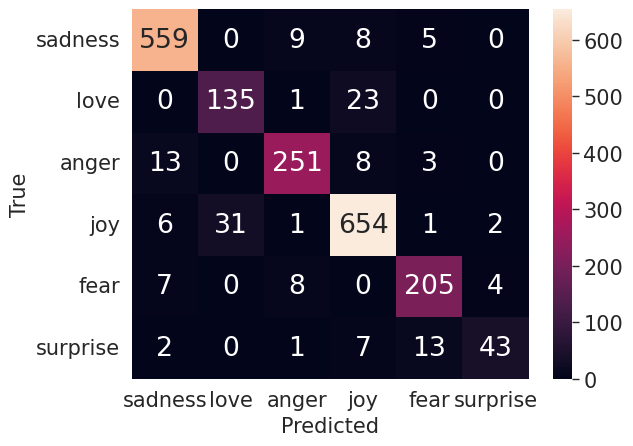

In [ ]:
conf_mat = metrics.confusion_matrix(y_true, y_pred)
ax = sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    xticklabels=list(LABELS_MAP.keys()),
    yticklabels=list(LABELS_MAP.keys())
)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [ ]:
save_vectorizer(vectorizer, 'rnn_glove_vectorizer')